# Advanced radiation and remote sensing


Manfred Brath, Oliver Lemke

## Exercise 5: Inversion theory: Optimal Estimation Method (OEM)

In [1]:
%matplotlib widget

import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import inv

from pyarts import xml
from oem import forward_model

os.makedirs("plots", exist_ok=True)

## In this exercise you will work with "realistic" data measured by a water  
vapor radiometer. The data is not real but has been simulated for a well-  
known atmospheric state using ARTS. Simulated measurements allow to  
compare retrieval results to the true atmospheric state. The radiometer  
(image below) measures thermal radiation in a frequency range around the  
$22\,\text{GHz}$ water vapor absorption line.   
As the pressure broadening of absorption lines varies with height the  
measurement contains information about the vertical water vapor profile.  
This information can be retrieved using the "Optimal Estimation Method" (OEM).   
The radiometer is placed in $10\,\text{km}$ height, which resembles an upward  
looking airborne measurement. The scarce concentration of water vapor in the   
stratosphere allows to perform a linear retrieval approach. Retrievals that  
cover the whole atmosphere, including the highly absorbent lower troposphere,  
need more advanced retrieval approaches like an iterative OEM. 

![radiometer](H2Orad.jpg)

* Run the next cell.

In [2]:
# Load the (simulated) measurement.
measurement = xml.load("input/measurement_T.xml")
f_grid = measurement.grids[0]
y_measurement = measurement.data

# Load the a priori atmospheric state.
atm_fields = xml.load("input/x_apriori.xml")
z = atm_fields.get("z", keep_dims=False)
x_apriori = atm_fields.get("T", keep_dims=False)

# Load the covariance matrices.
S_xa = xml.load("input/S_xa_T.xml")
S_y = 0.25 * np.eye(f_grid.size)  # in [K^2]

* Plot the observed brightness
temperature spectrum `y_measurement` as function of frequency
`f_grid`.

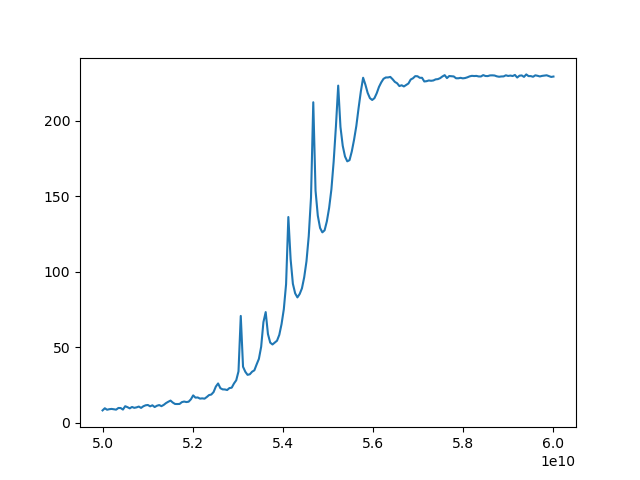

In [3]:
# Plot the y measurement.
# Plot the y measurement.
fig, ax = plt.subplots(1,1)
ax.plot(f_grid, y_measurement, label="y measurement")

* Run the next cell to simulate the brightness temperature spectrum 
`y` and the water vapor Jacobian `K` for  
the *a priori* state.

In [4]:
# Run the forward model (ARTS).
y, K = forward_model(f_grid, atm_fields, retrieval_quantity='Temperature')

* Plot the simulated brightness temperature spectrum alongside with
the observed brightness temperature spectrum.

In [5]:
# Plot the y measurement alongside the simulated y for the a priori.
ax.plot(f_grid, y, label="y forward model")

* Plot the Jacobians `K` in a suitable way. Explain the plot.

Text(0.5, 1.0, 'Jacobian K')

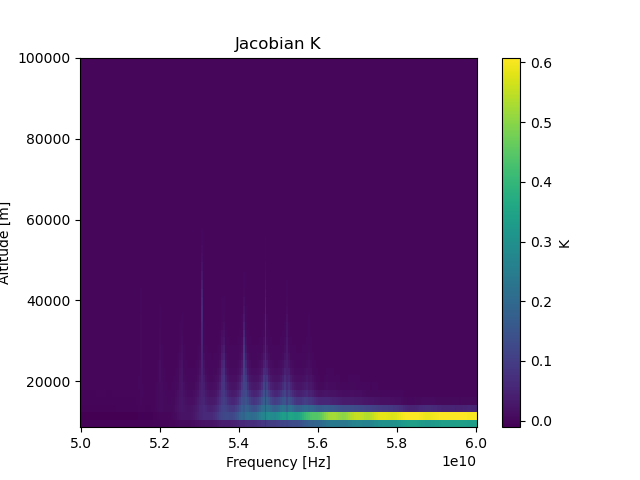

In [6]:
# Plot the Jacobians.

fig1, ax1 = plt.subplots(1,1)
pcm=ax1.pcolormesh(f_grid, z, K.T, shading="auto")
fig1.colorbar(pcm, ax=ax1, label="K")
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Altitude [m]")
ax1.set_title("Jacobian K")

* Plot the measurement covariance matrix `S_y` and the *apriori*  covariance matrix `S_xa` in a suitable way.  
What do the covariance matrices mean?

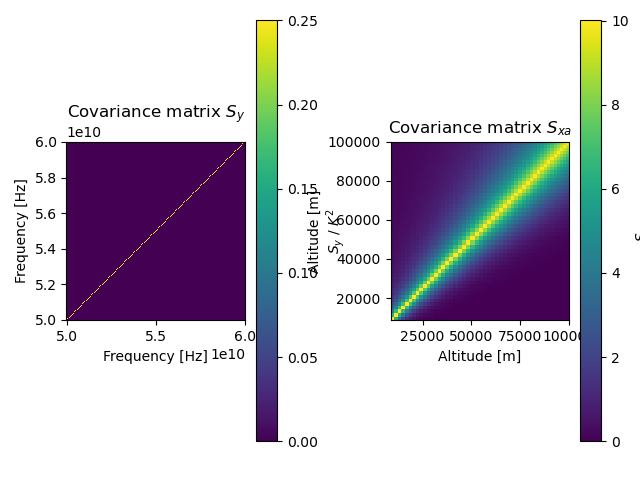

In [7]:
# Plot the covariance matrices.
fig2, ax2 = plt.subplots(1,2)

pcm = ax2[0].pcolormesh(f_grid, f_grid, S_y, shading="auto")
fig2.colorbar(pcm, ax=ax2[0], label="$S_y$ / $K^2$")
ax2[0].set_xlabel("Frequency [Hz]")
ax2[0].set_ylabel("Frequency [Hz]")
ax2[0].set_title("Covariance matrix $S_y$")
ax2[0].set_aspect('equal', 'box')
fig2.tight_layout()


pcm = ax2[1].pcolormesh(z, z, S_xa, shading="auto")
fig2.colorbar(pcm, ax=ax2[1], label="$S_{xa}$")
ax2[1].set_xlabel("Altitude [m]")
ax2[1].set_ylabel("Altitude [m]")
ax2[1].set_title("Covariance matrix $S_{xa}$")
ax2[1].set_aspect('equal', 'box')

* Implement the function `retrieve()` according to the OEM solution:  
$$\hat{\mathbf{x}}=\mathbf{x}_{a}+\left(\mathbf{K}^{T}\mathbf{S}_{y}^{-1}\mathbf{K}+\mathbf{S}_{xa}^{-1}\right)^{-1}\mathbf{K}^{T}\mathbf{S}_{y}^{-1}\left(\mathbf{y}_{measure}-\mathbf{y}_{a}\right)$$

 with $\mathbf{x}_{a}$ the a priori profile, $\mathbf{K}$ the Jacobian,
$\mathbf{S}_{y}$ the measurement covariance matrix, $\mathbf{S}_{xa}$
the *a priori* covariance matrix, $\mathbf{y}_{measure}$ the
observed brightness temperature spectrum and $\mathbf{y}_{a}$ the
simulated brightness temperature spectrum of profile $\mathbf{x}_{a}$.  
In Python, a matrix `M` can be transposed using `M.T`
and inversed using `inv(M)` We are using the inverse function 
`scipy.linalg.inv()` provided by the SciPy package. 
Two matrices `M1` and `M2` can be multiplied using
`M1 @ M2.`

* Use the function `retrieve()` to retrieve the water vapor profile.

In [8]:
# Implement the retrieve function.
def retrieve(y, K, xa, ya, Sa, Sy):
    """Perform an OEM retrieval.

    Parameters:
        y (np.ndarray): Measuremed brightness temperature [K].
        K (np.ndarray): Jacobians [K/1].
        xa (np.ndarray): A priori state [VMR].
        ya (np.ndarray): Forward simulation of a priori state ``F(xa)`` [K].
        Sa (np.ndarray): A priori error covariance matrix.
        Sy (np.ndarray): Measurement covariance matrix

    Returns:
        np.ndarray: Retrieved atmospheric state.

    """
    return xa + inv(K.T @ inv(Sy) @ K + inv(Sa)) @ K.T @ inv(Sy) @ (y - ya)

In [9]:
# retrieve
x_oem = retrieve(y_measurement, K, x_apriori, y, S_xa, S_y)


* Plot the retrieved water vapor `x_oem` and the *a priori* 
water vapor profile as function of height `z`.

* Load the true water vapor retrieval (`input/x_true.xml`) and
add it to the previous plot. Dicuss the results.

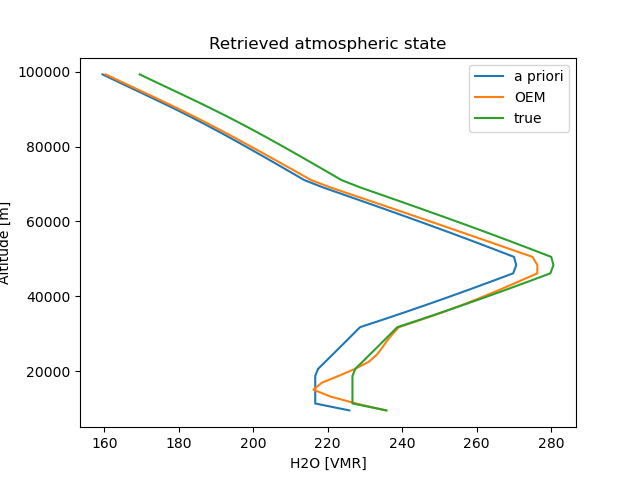

In [10]:
# Plot the OEM result next to the true atmospheric state and the a priori.
fig3, ax3 = plt.subplots(1,1)
ax3.plot(x_apriori, z, label="a priori")
ax3.plot(x_oem, z, label="OEM") 

ax3.set_xlabel("H2O [VMR]")
ax3.set_ylabel("Altitude [m]")
ax3.set_title("Retrieved atmospheric state")    

atm_true = xml.load("input/x_true_T.xml")
x_true = atm_true.get("T", keep_dims=False)
ax3.plot(x_true, z, label="true")
ax3.legend()

* Implement the function `gain_matrix()` to calculate
the same-named matrix:  
$$\mathbf{G}=\left(\mathbf{K}^{T}\mathbf{S}_{y}^{-1}\mathbf{K}+\mathbf{S}_{xa}^{-1}\right)^{-1}\mathbf{K}^{T}\mathbf{S}_{y}^{-1}$$

In [11]:
# Implement the averaging_kernel_matrix function.
def gain_matrix(K, Sa, Sy):
    """Calculate the gain matrix.

    Parameters:
        K (np.ndarray): Simulated Jacobians.
        Sa (np.ndarray): A priori error covariance matrix.
        Sy (np.ndarray): Measurement covariance matrix.

    Returns:
        np.ndarray: gain matrix.
    """
    return inv(K.T @ inv(Sy) @ K + inv(Sa)) @ K.T @ inv(Sy)

* Plot the gain matrix `G` in a suitable way. 
* Explain where which part of the measurement vector contributes to the retrieval.


In [12]:
# Calculate gain matrix 
G = gain_matrix(K, S_xa, S_y)

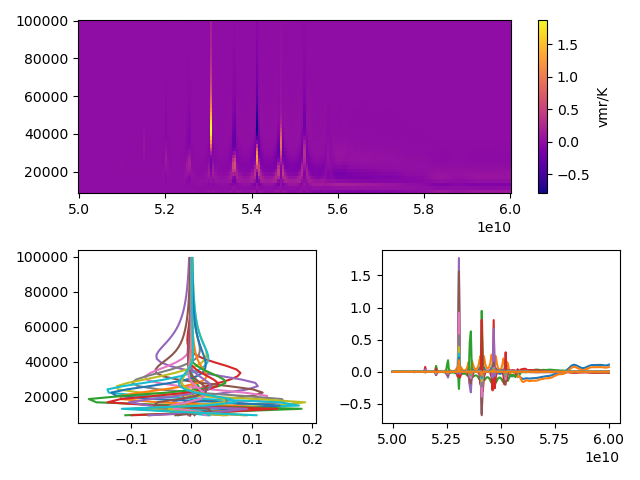

In [13]:
# Plot gain matrix
fig=plt.figure()
ax1 = plt.subplot(2,2, (1,2) )
pcm=ax1.pcolormesh(f_grid,z,G, cmap="plasma")
fig.colorbar(pcm, ax=ax1, label="vmr/K")

ax2 = plt.subplot(2,2,3 )
ax2.plot(G[:,::10],z)

ax3 = plt.subplot(2,2,4 )
ax3.plot(f_grid, G[::4,:].T)

fig.tight_layout()


* Implement the function `averaging_kernel_matrix()` to calculate
the same-named matrix:  
$$\mathbf{A}=\left(\mathbf{K}^{T}\mathbf{S}_{y}^{-1}\mathbf{K}+\mathbf{S}_{xa}^{-1}\right)^{-1}\mathbf{K}^{T}\mathbf{S}_{y}^{-1}\mathbf{K}$$

In [14]:
# Implement the averaging_kernel_matrix function.
def averaging_kernel_matrix(K, Sa, Sy):
    """Calculate the averaging kernel matrix.

    Parameters:
        K (np.ndarray): Simulated Jacobians.
        Sa (np.ndarray): A priori error covariance matrix.
        Sy (np.ndarray): Measurement covariance matrix.

    Returns:
        np.ndarray: Averaging kernel matrix.
    """
    return inv(K.T @ inv(Sy) @ K + inv(Sa)) @ K.T @ inv(Sy) @ K

* Plot the kernels (columns) of $\mathbf{A}$ as function of height
`z` and interpret the results.  
The measurement response is defined as the sum over all averaging
kernels in a given height (row). The measurement response indicates
in which heights the measurement actually adds information to the
retrieval result.
* Calculate the measurement response and plot it together with the averaging
kernels.
* In which heights does the measurement provide useful information?
* Is it possible to estimate the vertical resolution?

In [15]:
# Calculate averaging kernel 
A = averaging_kernel_matrix(K, S_xa, S_y)

Text(0.5, 1.0, 'contribution')

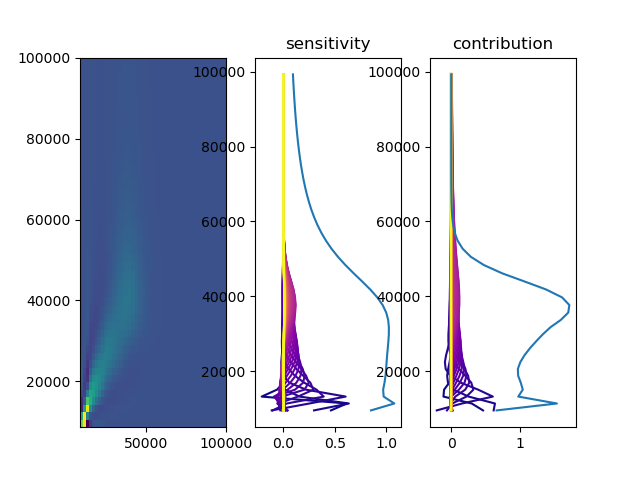

In [16]:
# Plot averaging kernels
fig, ax =plt.subplots(1,3)
pcm=ax[0].pcolormesh(z,z,A)

from matplotlib import colormaps as cm
cmap =cm['plasma']
colors = cmap(np.linspace(0, 1, len(z)))
for i in range(len(z)):
    ax[1].plot(A[i,:],z,color=colors[i])
test=np.sum(A,1)
ax[1].plot(test,z)
ax[1].set_title("sensitivity")

for i in range(len(z)):
    ax[2].plot(A[:,i],z,color=colors[i])
test=np.sum(A,0)
ax[2].plot(test,z)    
ax[2].set_title("contribution")
